In [1]:
import netCDF4
import numpy as np
from scipy import stats
import glob
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# This script plots <font color='blue'>Figure 4</font> in Penn & Holloway 2020
from Penn & Holloway 2020. 

**Input:** 
- GOME-2 files averaged over a month (or several months) using *average_0_5_gome2_omi.py*
- These files are in the folder `level3data`.
    - Note that this script ensures that a pixel is used *only* if there is data for *both* GOME-2 and OMI for that day. 

**Output:**
- Figure 4 (Map of $NO_2$ over the US in 2007 for GOME-2, OMI, and the difference between them)

Change the `baseDir` to the folder where you downloaded the GitHub file to, and all the scrpts should work. 

*Created by Elise Penn; last modified 09/17/2020.*

In [2]:
# change this to the directory where you downloaded the github folder
baseDir = '/Volumes/Space/penn_holloway_github/'
directory = '{}level3data/'.format(baseDir)

# Full Summer
omiFile = 'OMI_0_25x0_25_from06-01-2007_to08-31-2007.nc'
go2File = 'GOME2_0_25x0_25_from06-01-2007_to08-31-2007.nc'

# # August
# omiFile = 'OMI_0_25x0_25_from08-01-2007_to08-31-2007.nc'
# go2File = 'GOME2_0_25x0_25_from08-01-2007_to08-31-2007.nc'

# # July
# omiFile = 'OMI_0_25x0_25_from07-01-2007_to07-31-2007.nc'
# go2File = 'GOME2_0_25x0_25_from07-01-2007_to07-31-2007.nc'

# # June
# omiFile = 'OMI_0_25x0_25_from06-01-2007_to06-30-2007.nc'
# go2File = 'GOME2_0_25x0_25_from06-01-2007_to06-30-2007.nc'

# # Full Summer 0.5x0.5
# omiFile = 'OMI_0_5x0_5_CONUS_OMNO2d_from06-01-2007_to08-31-2007.nc'
# go2File = 'GOME2_0_5x0_5_CONUS_OMNO2d_from06-01-2007_to08-31-2007.nc'

# # # August 0.5x0.5
# omiFile = 'OMI_0_5x0_5_CONUS_OMNO2d_from06-01-2007_to08-31-2007.nc'
# go2File = 'GOME2_0_5x0_5_CONUS_OMNO2d_from06-01-2007_to08-31-2007.nc'

# path to file where you store the grid file WHIPS outputs 
#### change this if you change resolution
gridFile = '{}WHIPS-output/0_25x0_25_CONUS_gridfile.nc'.format(baseDir)
# gridFile = '/Users/Elise/penn_holloway/WHIPS-output/DOMINO/grid0_5x0_5/CONUS_0_5x0_5_gridfile.nc'

fillValue = -9999.0

#date = '06-14-2007'

In [3]:
def read_in_sat(fileName):
    conc = netCDF4.Dataset(fileName).variables['NO2Conc']
    conc = np.where(conc==conc._FillValue, np.nan, conc)
    return conc

In [4]:
def load_drill_into_cannon(ul,ur,ll,lr):
    dataDim = ll.shape
    meshDim = (dataDim[0]+1,dataDim[1]+1)
    mesh = np.empty(meshDim)
    mesh[:] = np.nan
    for i in np.arange(dataDim[0]):
        for j in np.arange(dataDim[1]):
            if np.isnan(mesh[i+1][j]):
                mesh[i+1][j]= ul[i][j]            
            else:
                if mesh[i+1][j]!=ul[i][j]:
                    raise ValueError("Grid is not continuous.")

            if np.isnan(mesh[i+1][j+1]):
                mesh[i+1][j+1] = ur[i][j]
            else:
                if mesh[i+1][j+1]!=ur[i][j]:
                    raise ValueError("Grid is not continuous.")
                
            if np.isnan(mesh[i][j]):
                mesh[i][j] = ll[i][j]
            else:
                if mesh[i][j]!=ll[i][j]:
                    raise ValueError("Grid is not continuous.")
                
            if np.isnan(mesh[i][j+1]):
                mesh[i][j+1] = lr[i][j]
            else:
                if mesh[i][j+1] != lr[i][j]:
                    raise ValueError("Grid is not continuous.")
                    
    return mesh


def read_grid(gridFile):
    grid = netCDF4.Dataset(gridFile)
    ul_lat = grid.variables['ul_lat']
    ur_lat = grid.variables['ur_lat']
    ll_lat = grid.variables['ll_lat']
    lr_lat = grid.variables['lr_lat']
    latMesh = np.array(load_drill_into_cannon(ul_lat,ur_lat,ll_lat,lr_lat))
    
    ul_lon = grid.variables['ul_lon']
    ur_lon = grid.variables['ur_lon']
    ll_lon = grid.variables['ll_lon']
    lr_lon = grid.variables['lr_lon']
    lonMesh = np.array(load_drill_into_cannon(ul_lon,ur_lon,ll_lon,lr_lon))
            
    return latMesh, lonMesh

In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [6]:
# read in grid
gridlats, gridlons = read_grid(gridFile)

In [7]:
# load satellite data
omi = read_in_sat(directory+omiFile)
gome2 = read_in_sat(directory+go2File)

## Difference Map

In [8]:
bounds = True
lonlim = [-126.,-66.]
latlim = [24.,50.]

# set projection for grid
plate_caree = ccrs.PlateCarree()

# set size of figure, in inches
figX = 8.5
figY = 11

# adjust the colormap we're using for NO2
minColor = 0.13
maxColor = 0.75
jet_t = truncate_colormap(plt.get_cmap("gist_ncar"), minColor, maxColor)
colormap = jet_t

# settings for the NO2 norm
minvalue = 0.
maxvalue = 21.
delta = 1.0
no2Boundaries = np.arange(minvalue,maxvalue,delta)
norm = mcolors.BoundaryNorm(boundaries=no2Boundaries, ncolors=colormap.N)

# set up NO2 tick lables and add '<' and '>' to first and last items
no2Ticks = np.arange(no2Boundaries[0],no2Boundaries[-1]+delta/2,4)
no2TickLabels = [format(x,'.0f') for x in no2Ticks]
no2TickLabels[0] = '<'+str(no2TickLabels[0])
no2TickLabels[-1] = '>'+str(no2TickLabels[-1])

# settings for the difference norm
diffVMin = -7.5
diffVMax = 8.
diffDelta = 0.75
# diffVMin = -7.5
# diffVMax = 8.
# diffDelta = 1.0
diffBoundaries = np.arange(diffVMin,diffVMax,diffDelta)
diffColormap = plt.get_cmap("RdBu_r")
normDiff = mcolors.BoundaryNorm(boundaries=diffBoundaries, ncolors=diffColormap.N)

# set up difference tick lables and add '<' and '>' to first and last items
diffTicks = np.linspace(diffBoundaries[0],diffBoundaries[-1],3)
diffTickLabels = [str(x) for x in diffTicks]
diffTickLabels[0] = '<'+str(diffTickLabels[0])
diffTickLabels[-1] = '>'+str(diffTickLabels[-1])

states_provinces = cfeature.NaturalEarthFeature(
                    category='cultural',
                    name='admin_1_states_provinces_lines',
                    scale='10m',
                    facecolor='none')

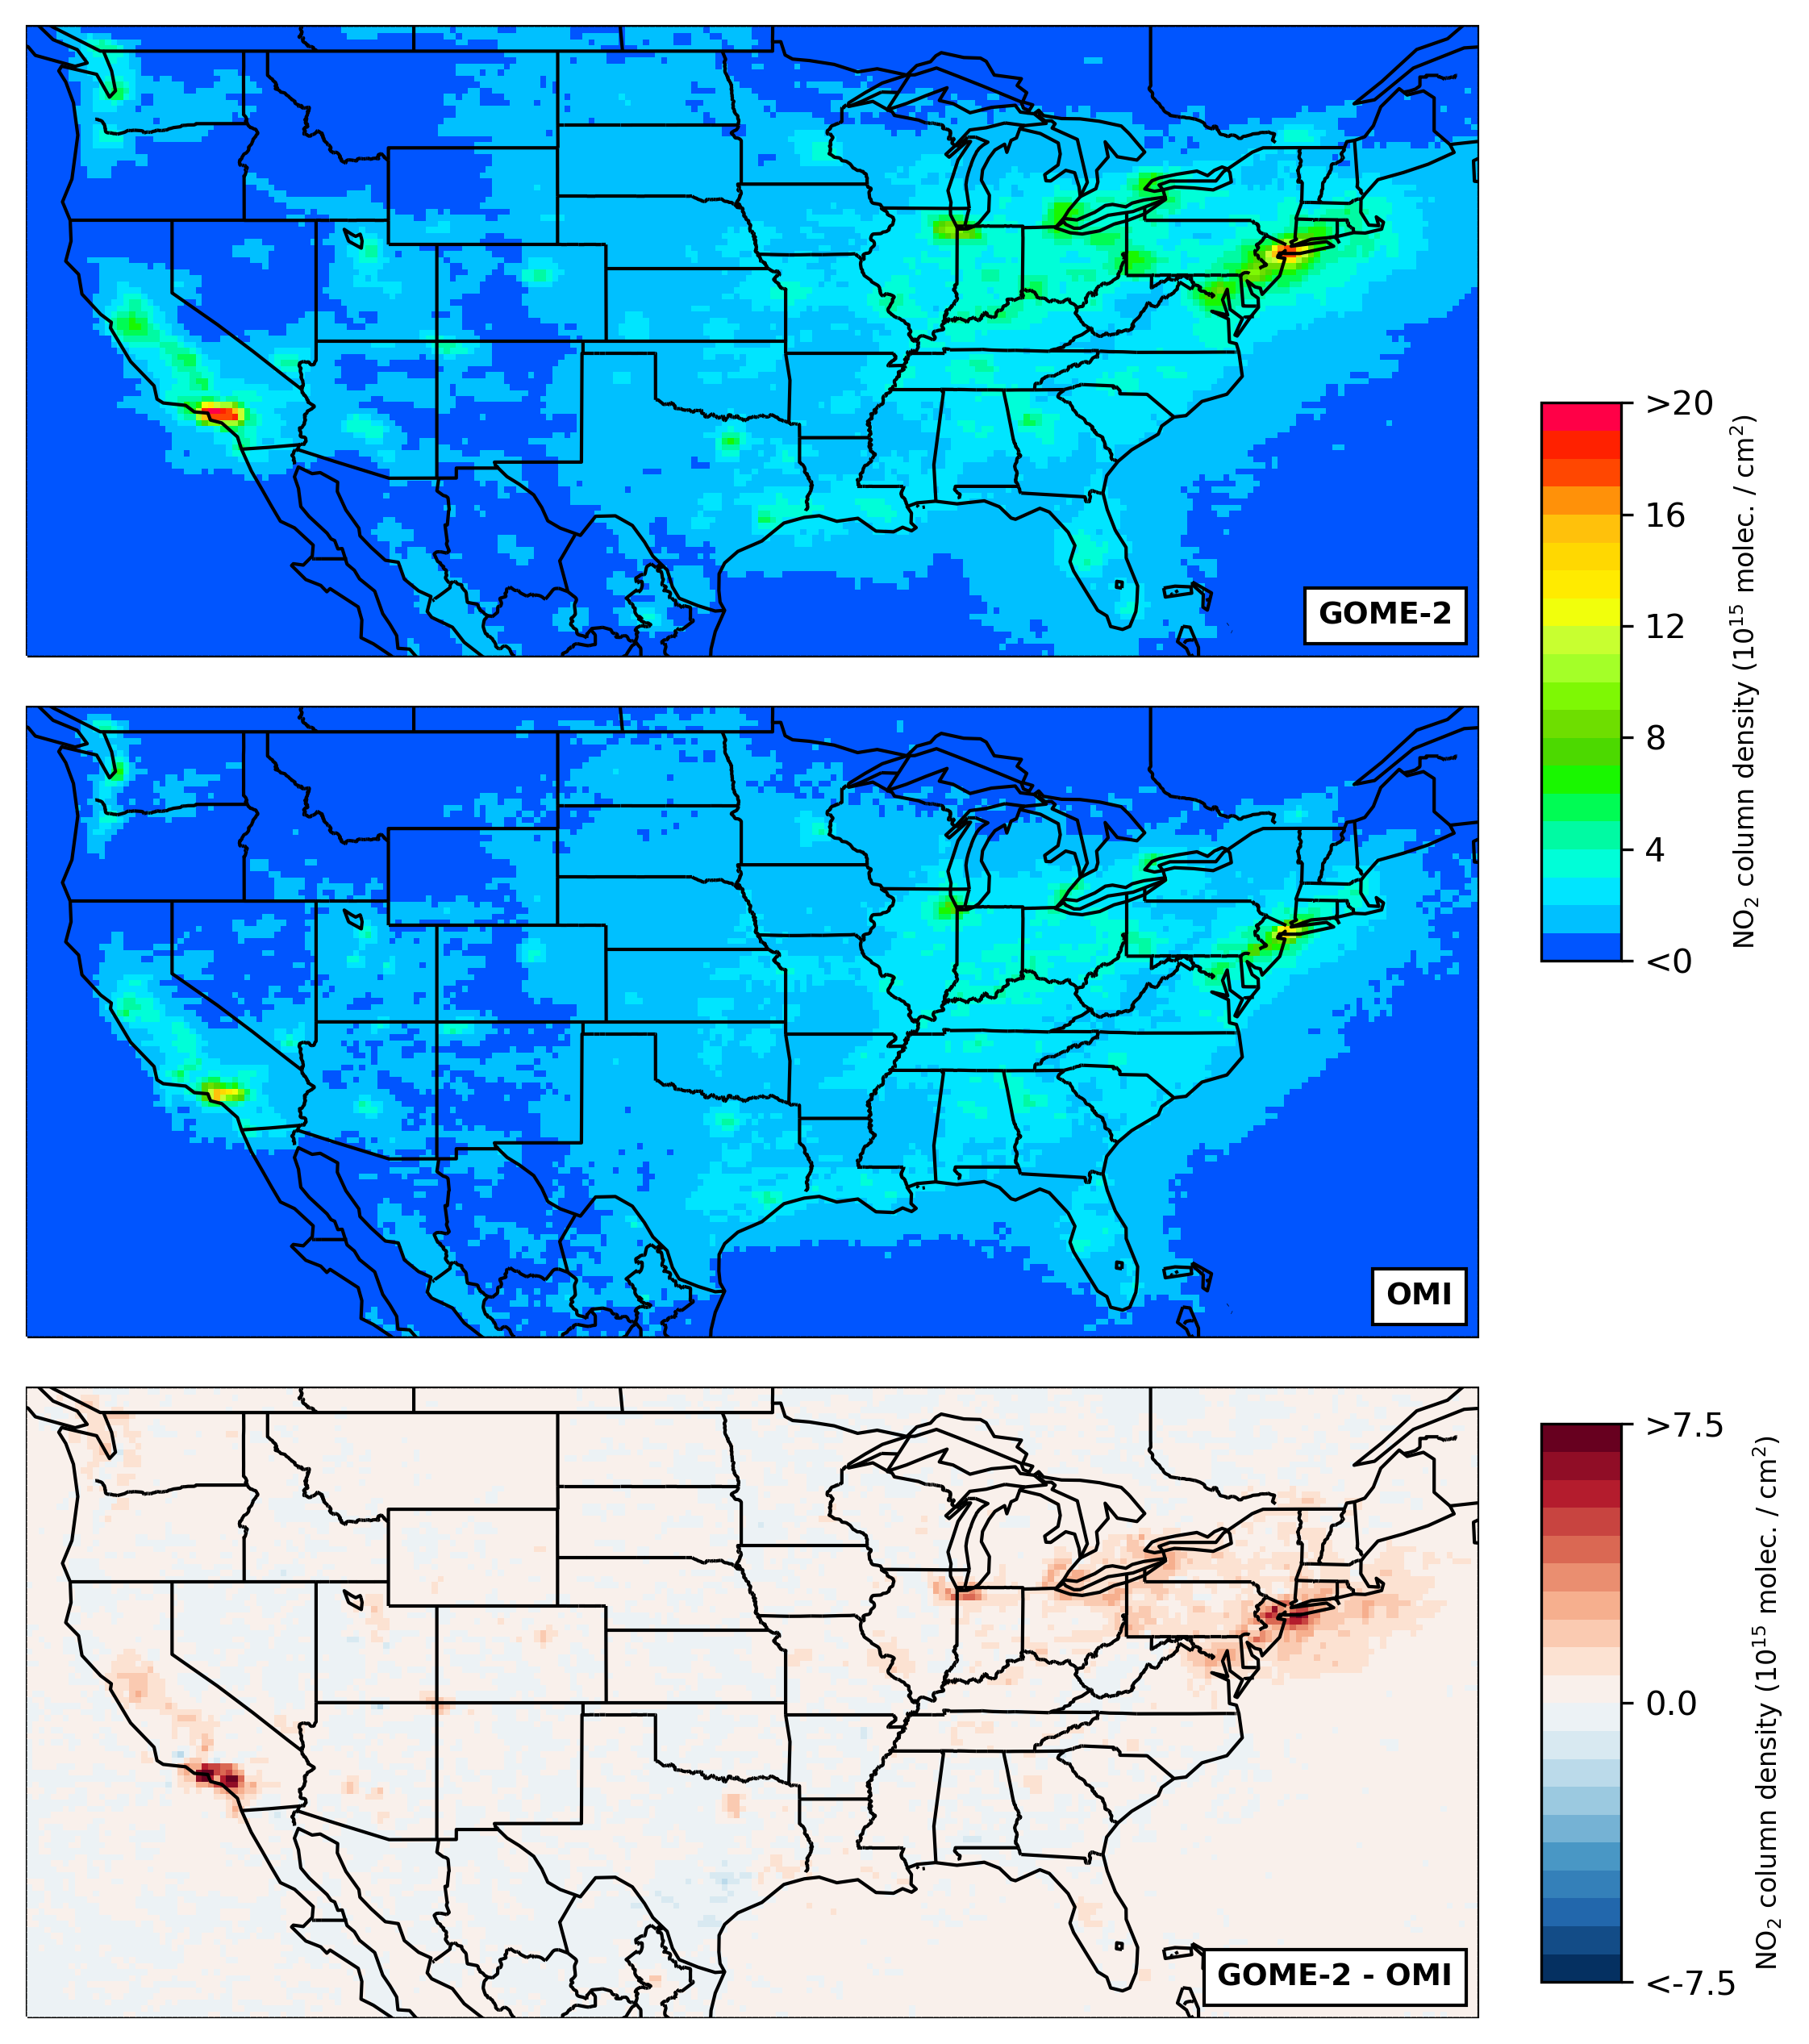

In [9]:
# set up a map
figBoth, (axG,axO,axD) = plt.subplots(nrows=3, ncols=1, sharex='all', sharey='all',
                                        subplot_kw={'projection': ccrs.PlateCarree()}, 
                                        gridspec_kw={'hspace':0.05},
                                        figsize=(figX,figY), dpi=300)

# plot the raster data and define the map features
# plot GOME-2
go2Plot = axG.pcolormesh(gridlons, gridlats, gome2, transform=plate_caree, 
               cmap=colormap, norm=norm, antialiased=False, zorder=3)
axG.add_feature(cfeature.COASTLINE,zorder=5)
axG.add_feature(cfeature.BORDERS,zorder=4)
axG.add_feature(cfeature.LAKES,edgecolor='black', zorder=6,facecolor='None')
#axG.add_feature(cfeature.OCEAN, facecolor='white', zorder=4)
axG.add_feature(states_provinces, edgecolor='black', zorder = 4)
axG.text(0.983,0.04, 'GOME-2', verticalalignment='bottom', horizontalalignment='right',
         transform=axG.transAxes, fontweight='bold', fontsize=9, zorder=99,
         bbox=dict(facecolor='white', edgecolor='black', alpha=1))

# plot OMI
omiPlot = axO.pcolormesh(gridlons, gridlats, omi, transform=plate_caree, 
               cmap=colormap, norm=norm, antialiased=False, zorder=3)
axO.add_feature(cfeature.COASTLINE,zorder=5)
axO.add_feature(cfeature.BORDERS,zorder=4)
axO.add_feature(cfeature.LAKES,edgecolor='black', zorder=6,facecolor='None')
#axO.add_feature(cfeature.OCEAN, facecolor='white', zorder=4)
axO.add_feature(states_provinces, edgecolor='black', zorder = 4)
axO.text(0.983,0.04, 'OMI', verticalalignment='bottom', horizontalalignment='right',
         transform=axO.transAxes, fontweight='bold', fontsize=9, zorder=99,
         bbox=dict(facecolor='white', edgecolor='black', alpha=1))

# plot Difference
diffPlot = axD.pcolormesh(gridlons, gridlats, gome2-omi, transform=plate_caree, 
               cmap=diffColormap, norm=normDiff, antialiased=False, zorder=3)
axD.add_feature(cfeature.COASTLINE,zorder=5)
axD.add_feature(cfeature.BORDERS,zorder=4)
axD.add_feature(cfeature.LAKES, edgecolor='black', zorder=6,facecolor='None')
#axD.add_feature(cfeature.OCEAN, facecolor='white', zorder=4)
axD.add_feature(states_provinces, edgecolor='black', zorder = 4)
axD.text(0.983,0.04, 'GOME-2 - OMI', verticalalignment='bottom', horizontalalignment='right',
         transform=axD.transAxes, fontweight='bold', fontsize=9, zorder=99,
         bbox=dict(facecolor='white', edgecolor='black', alpha=1))

if bounds:
    axG.set_extent([lonlim[0],lonlim[1],latlim[0],latlim[1]], crs=ccrs.PlateCarree())
    axO.set_extent([lonlim[0],lonlim[1],latlim[0],latlim[1]], crs=ccrs.PlateCarree())
    axD.set_extent([lonlim[0],lonlim[1],latlim[0],latlim[1]], crs=ccrs.PlateCarree())
    
# set up colorbars
no2Cbar = figBoth.colorbar(go2Plot, orientation='vertical', ax=[axG,axO], 
                 fraction=0.050, pad=0.04, aspect=7, ticks=no2Ticks)
diffCbar = figBoth.colorbar(diffPlot, orientation='vertical', ax=axD, 
                 fraction=0.050, pad=0.04, aspect=7, ticks=diffTicks)
# Manually assign tickmarks. Add > and < to first and last label.
no2Cbar.ax.set_yticklabels(no2TickLabels)
diffCbar.ax.set_yticklabels(diffTickLabels)
# add titles to both cbars
no2Cbar.ax.set_ylabel('NO$_2$ column density (10$^{15}$ molec. / cm$^2$)',fontsize=8)
diffCbar.ax.set_ylabel('NO$_2$ column density (10$^{15}$ molec. / cm$^2$)',fontsize=8)


#figBoth.set_size_inches(figX,figY)

plt.show()

## Ratio Map

In [10]:
bounds = True
lonlim = [-126.,-66.]
latlim = [24.,50.]

# set projection for grid
plate_caree = ccrs.PlateCarree()

# set size of figure, in inches
figX = 8.5
figY = 11

# adjust the colormap we're using for NO2
minColor = 0.13
maxColor = 0.75
jet_t = truncate_colormap(plt.get_cmap("gist_ncar"), minColor, maxColor)
colormap = jet_t

# settings for the NO2 norm
minvalue = 0.
maxvalue = 21.
delta = 1.0
no2Boundaries = np.arange(minvalue,maxvalue,delta)
norm = mcolors.BoundaryNorm(boundaries=no2Boundaries, ncolors=colormap.N)

# set up NO2 tick lables and add '<' and '>' to first and last items
no2Ticks = np.arange(no2Boundaries[0],no2Boundaries[-1]+delta/2,4)
no2TickLabels = [format(x,'.0f') for x in no2Ticks]
no2TickLabels[0] = '<'+str(no2TickLabels[0])
no2TickLabels[-1] = '>'+str(no2TickLabels[-1])

# settings for the difference norm
diffVMin = 0.
diffVMax = 2.1
diffDelta = 0.2
diffBoundaries = np.arange(diffVMin,diffVMax,diffDelta)

diffColormap = plt.get_cmap("RdBu_r")
normDiff = mcolors.BoundaryNorm(boundaries=diffBoundaries, ncolors=diffColormap.N)

# set up difference tick lables and add '<' and '>' to first and last items
diffTicks = np.linspace(diffBoundaries[0],diffBoundaries[-1],3)
diffTickLabels = [str(x) for x in diffTicks]
diffTickLabels[0] = '<'+str(diffTickLabels[0])
diffTickLabels[-1] = '>'+str(diffTickLabels[-1])

states_provinces = cfeature.NaturalEarthFeature(
                    category='cultural',
                    name='admin_1_states_provinces_lines',
                    scale='10m',
                    facecolor='none')

In [11]:
diffBoundaries

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])

In [12]:
diffTicks

array([0., 1., 2.])

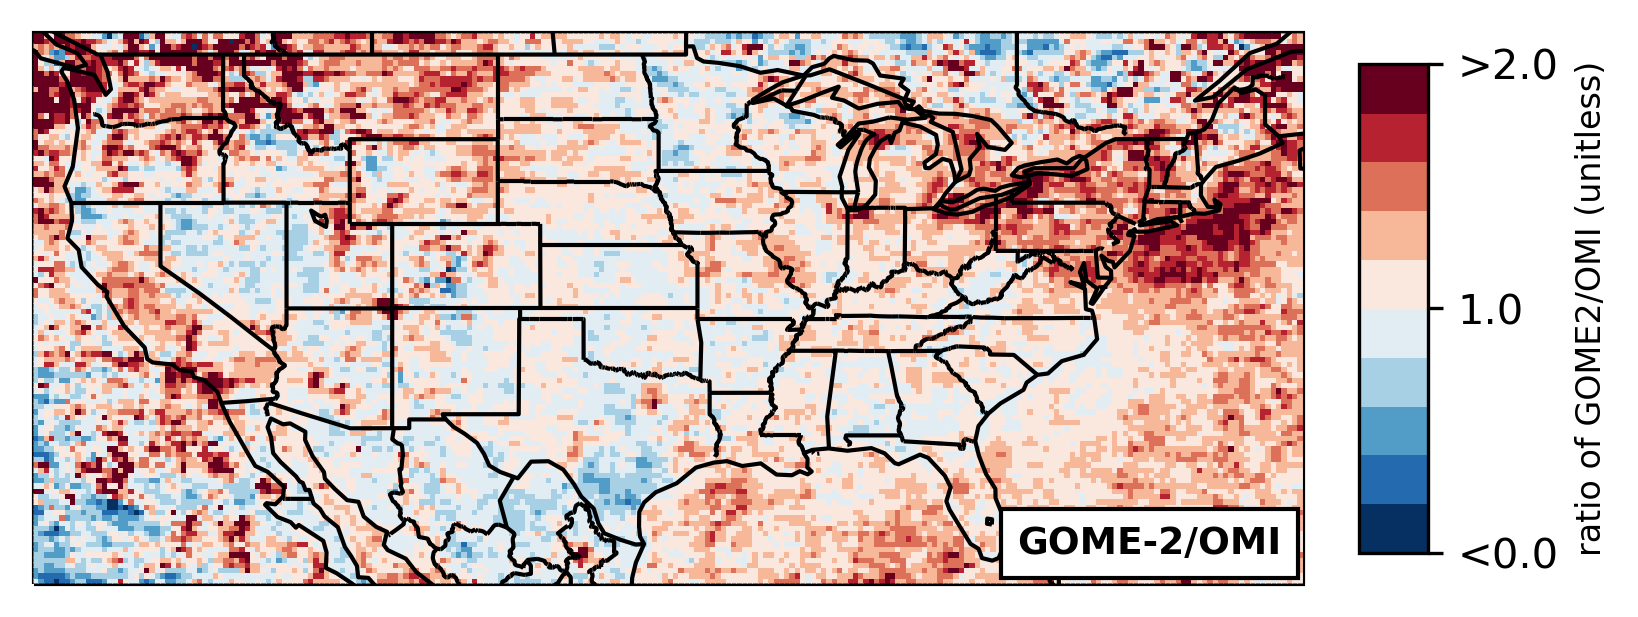

In [13]:
fig, axD = plt.subplots(nrows=1, ncols=1, sharex='all', sharey='all',
                                        subplot_kw={'projection': ccrs.PlateCarree()}, 
                                        gridspec_kw={'hspace':0.05}, dpi=300) #figsize=(figX,figY)

# plot Ratio
diffPlot = axD.pcolormesh(gridlons, gridlats, gome2/omi, transform=plate_caree, 
               cmap=diffColormap, norm=normDiff, antialiased=False, zorder=3)
axD.add_feature(cfeature.COASTLINE,zorder=5)
axD.add_feature(cfeature.BORDERS,zorder=4)
axD.add_feature(cfeature.LAKES, edgecolor='black', zorder=6,facecolor='None')
#axD.add_feature(cfeature.OCEAN, facecolor='white', zorder=4)
axD.add_feature(states_provinces, edgecolor='black', zorder = 4)
axD.text(0.983,0.04, 'GOME-2/OMI', verticalalignment='bottom', horizontalalignment='right',
         transform=axD.transAxes, fontweight='bold', fontsize=9, zorder=99,
         bbox=dict(facecolor='white', edgecolor='black', alpha=1))

if bounds:
    axG.set_extent([lonlim[0],lonlim[1],latlim[0],latlim[1]], crs=ccrs.PlateCarree())
    axO.set_extent([lonlim[0],lonlim[1],latlim[0],latlim[1]], crs=ccrs.PlateCarree())
    axD.set_extent([lonlim[0],lonlim[1],latlim[0],latlim[1]], crs=ccrs.PlateCarree())
    
# set up colorbars
diffCbar = figBoth.colorbar(diffPlot, orientation='vertical', ax=axD, 
                 fraction=0.050, pad=0.04, aspect=7, ticks=diffTicks)
# Manually assign tickmarks. Add > and < to first and last label.
diffCbar.ax.set_yticklabels(diffTickLabels) 
# add titles to both cbars
diffCbar.ax.set_ylabel('ratio of GOME2/OMI (unitless)',fontsize=8)


#figBoth.set_size_inches(figX,figY)

plt.show()